In [10]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from keras.utils import to_categorical
from keras.utils import img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping  
import math
import datetime
import time

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [11]:
# Default dimensions for VGG19
img_width, img_height = 224, 224

# Create a bottleneck file
top_model_weights_path = 'pytorch_bottleneck_fc_model_vgg19.h5'

# Loading up our datasets
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

# Number of epochs to train top model
epochs = 100  # This has been changed after multiple model runs
# Batch size used by flow_from_directory and predict_generator
batch_size = 50

In [12]:
# Load pre-trained VGG19 model in PyTorch
pytorch_model = models.vgg19(pretrained=True)

# Modify the last layer for feature extraction
num_ftrs = pytorch_model.classifier[-1].in_features
pytorch_model.classifier[-1] = nn.Identity()

# Define transforms for images
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_data_dir, transform=transform)
validation_dataset = ImageFolder(validation_data_dir, transform=transform)
test_dataset = ImageFolder(test_data_dir, transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Feature extraction for training data
start = datetime.datetime.now()
train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        features = pytorch_model(images)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)
np.save('train_features_vgg19.npy', train_features.numpy())
np.save('train_labels_vgg19.npy', train_labels.numpy())
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction time for training data:', elapsed)

# Feature extraction for validation data
start = datetime.datetime.now()
validation_features = []
validation_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        features = pytorch_model(images)
        validation_features.append(features)
        validation_labels.append(labels)

validation_features = torch.cat(validation_features)
validation_labels = torch.cat(validation_labels)
np.save('validation_features_vgg19.npy', validation_features.numpy())
np.save('validation_labels_vgg19.npy', validation_labels.numpy())
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction time for validation data:', elapsed)

# Feature extraction for test data
start = datetime.datetime.now()
test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        features = pytorch_model(images)
        test_features.append(features)
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)
np.save('test_features_vgg19.npy', test_features.numpy())
np.save('test_labels_vgg19.npy', test_labels.numpy())
end = datetime.datetime.now()
elapsed = end - start
print('Feature extraction time for test data:', elapsed)

# Load features and labels
train_data = np.load('train_features_vgg19.npy')
train_labels = np.load('train_labels_vgg19.npy')
validation_data = np.load('validation_features_vgg19.npy')
validation_labels = np.load('validation_labels_vgg19.npy')
test_data = np.load('test_features_vgg19.npy')
test_labels = np.load('test_labels_vgg19.npy')

# Convert target labels to one-hot encoded format
train_labels = to_categorical(train_labels, num_classes=20)
validation_labels = to_categorical(validation_labels, num_classes=20)
test_labels = to_categorical(test_labels, num_classes=20)

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extraction time for training data: 0:07:17.962048
Feature extraction time for validation data: 0:00:53.962709
Feature extraction time for test data: 0:00:48.781730


In [13]:
# Define the model architecture
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation=keras.layers.LeakyReLU(
    alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(128, activation=keras.layers.LeakyReLU(
    alpha=0.3)))
model.add(Dropout(0.3))
model.add(Dense(units=20, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

early_stopping = EarlyStopping(
    monitor='val_acc', patience=20, verbose=1, mode='max')

# Train the model
history = model.fit(train_data, train_labels,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[early_stopping])

# Save the trained model
model.save_weights(top_model_weights_path)

# Evaluate the model on the test data
(eval_loss, eval_accuracy) = model.evaluate(
    test_data, test_labels, batch_size=batch_size, verbose=1)

# Print the evaluation results
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
31/31 [==============================] - 2s 26ms/step - loss: 3.1051 - acc: 0.2129 - val_loss: 1.3648 - val_acc: 0.6341
Epoch 2/200
31/31 [==============================] - 1s 16ms/step - loss: 1.2427 - acc: 0.6335 - val_loss: 0.7743 - val_acc: 0.8354
Epoch 3/200
31/31 [==============================] - 1s 16ms/step - loss: 0.7108 - acc: 0.7996 - val_loss: 0.5724 - val_acc: 0.8598
Epoch 4/200
31/31 [==============================] - 1s 17ms/step - loss: 0.4893 - acc: 0.8576 - val_loss: 0.4680 - val_acc: 0.8841
Epoch 5/200
31/31 [==============================] - 1s 17ms/step - loss: 0.3418 - acc: 0.9038 - val_loss: 0.4185 - val_acc: 0.8902
Epoch 6/200
31/31 [==============================] - 1s 17ms/step - loss: 0.2634 - acc: 0.9268 - val_loss: 0.3910 - val_acc: 0.8963
Epoch 7/200
31/31 [==============================] - 1s 18ms/step - loss: 0.2056 - acc: 0.9486 - val_loss: 0.3753 - val_acc: 0.8902
Epoch 8/200
31/31 [==============================] - 1s 20ms/step - loss: 0.

In [14]:
filepath = 'model_save_vgg19.h5'
keras.models.save_model(model, filepath)

In [15]:
model.save('savevgg19.h5')

In [16]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2097664   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 2,165,908
Trainable params: 2,165,908
Non-

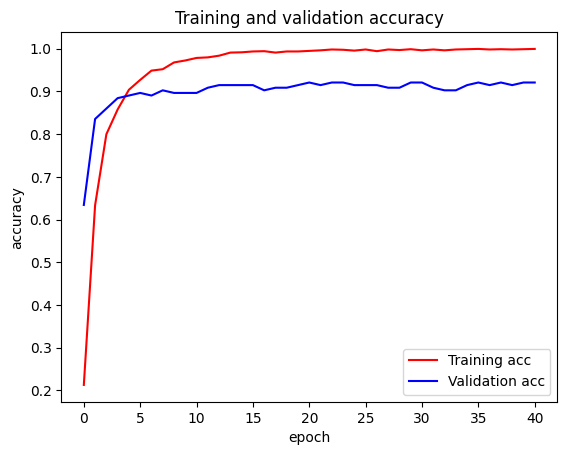

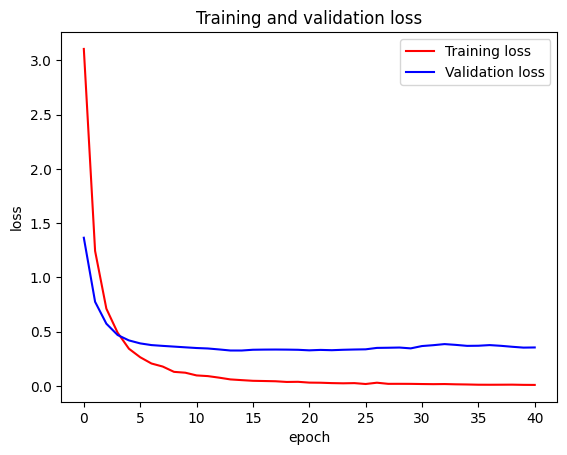

In [17]:
# Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [18]:
model.evaluate(test_data, test_labels)

6/6 [==============================] - 0s 5ms/step - loss: 0.2361 - acc: 0.9207


[0.2360653132200241, 0.9207317233085632]

In [19]:
print('test data', test_data)
preds = np.round(model.predict(test_data), 0)
# to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[0.        0.        0.        ... 0.        0.        0.       ]
 [1.2718251 0.        0.        ... 0.        5.4476757 0.       ]
 [0.        0.        0.        ... 0.        3.9993691 0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        8.919423  0.        ... 0.        0.        0.       ]
 [0.        5.7333794 0.        ... 0.        0.        0.       ]]
6/6 [==============================] - 0s 3ms/step
rounded test_labels [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [20]:
animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat',
           'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']
classification_metrics = metrics.classification_report(
    test_labels, preds, target_names=animals)
print(classification_metrics)

              precision    recall  f1-score   support

        bear       1.00      1.00      1.00        10
      cougar       0.90      0.90      0.90        10
      coyote       0.90      0.90      0.90        10
         cow       0.90      0.90      0.90        10
  crocodiles       1.00      1.00      1.00        10
        deer       0.75      0.90      0.82        10
    elephant       1.00      1.00      1.00        10
     giraffe       1.00      0.83      0.91         6
        goat       1.00      0.44      0.62         9
     gorilla       1.00      1.00      1.00         6
       horse       0.91      1.00      0.95        10
    kangaroo       0.86      0.86      0.86         7
     leopard       1.00      0.90      0.95        10
        lion       1.00      1.00      1.00         9
       panda       1.00      1.00      1.00         8
     penguin       1.00      1.00      1.00         5
       sheep       0.80      0.80      0.80         5
       skunk       1.00    

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
# Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [22]:
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 8)):  # Adjust the figsize as per your preference
    # Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Set figure size
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    # Rotate x-labels by 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Increase x-coordinate for more horizontal space
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


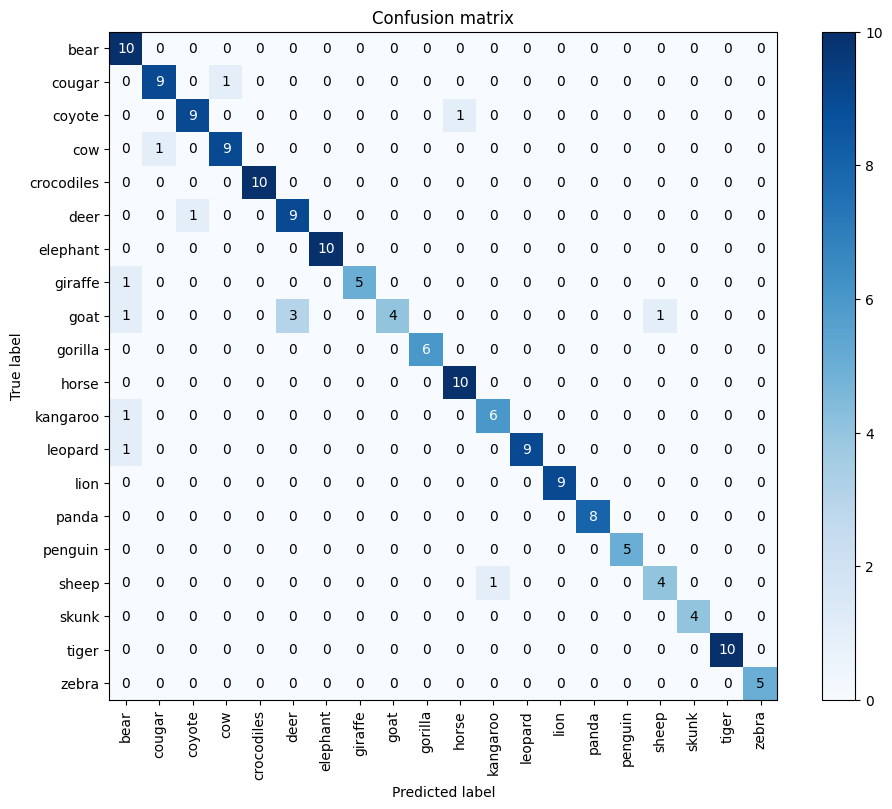

In [24]:
plot_confusion_matrix(confusion_matrix, ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe',
                      'goat', 'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'])

Normalized confusion matrix


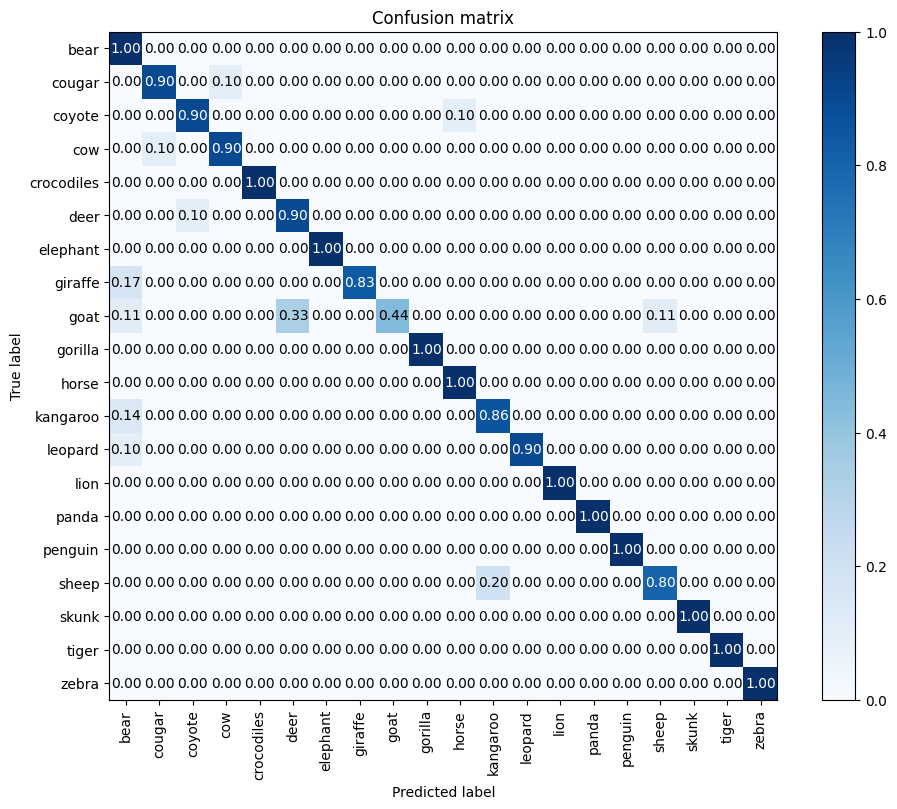

In [25]:
# Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix,
                      ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat', 'gorilla',
                          'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'],
                      normalize=True)

In [26]:
import time
import torch
from keras.utils import img_to_array, load_img


def read_image(path):
    # Resize images to match VGG19 input size
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = image.reshape((1,) + image.shape)  # Add batch dimension
    return image


def test_single_image(path):
    animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat',
               'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']

    # Read and preprocess the image
    image = read_image(path)
    time.sleep(0.5)

    # Convert image to torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    # Change dimension order to [batch_size, channels, height, width]
    image = image.permute(0, 3, 1, 2)
    image = image.to('cpu')  # Set to 'cuda' if you're using GPU

    # Extract features using the pretrained VGG19 model
    with torch.no_grad():
        features = pytorch_model(image)

    # Convert features to numpy array
    features = features.detach().numpy()

    # Make predictions using the trained model
    preds = model.predict(features)

    # Print individual class probabilities
    for idx, animal, prob in zip(range(0, 20), animals, preds[0]):
        print("ID: {}, Label: {} {}%".format(
            idx, animal, round(prob * 100, 2)))

    print('Final Decision:')
    time.sleep(0.5)

    # Simulate decision-making process
    for x in range(3):
        print('.'*(x+1))
        time.sleep(0.2)

    # Determine the predicted class
    class_prob = list(preds[0])
    max_prob = max(class_prob)
    pred_class = class_prob.index(max_prob)
    print("ID: {}, Label: {}".format(pred_class, animals[pred_class]))

    return load_img(path)

In [34]:
path = 'SUlIn0XjjZihkrEXHQMM--1--a6x8x.webp'

In [28]:
# # Load pre-trained VGG19 model in PyTorch
# pytorch_model = models.vgg19(pretrained=True)

In [29]:
# model = keras.models.load_model('model_save_vgg19.h5')

1/1 [==============================] - 0s 75ms/step
ID: 0, Label: bear 0.04%
ID: 1, Label: cougar 2.89%
ID: 2, Label: coyote 0.02%
ID: 3, Label: cow 0.13%
ID: 4, Label: crocodiles 0.05%
ID: 5, Label: deer 0.06%
ID: 6, Label: elephant 0.41%
ID: 7, Label: giraffe 0.05%
ID: 8, Label: goat 0.1%
ID: 9, Label: gorilla 0.25%
ID: 10, Label: horse 0.0%
ID: 11, Label: kangaroo 0.0%
ID: 12, Label: leopard 0.01%
ID: 13, Label: lion 0.0%
ID: 14, Label: panda 0.03%
ID: 15, Label: penguin 0.0%
ID: 16, Label: sheep 0.37%
ID: 17, Label: skunk 0.05%
ID: 18, Label: tiger 95.27%
ID: 19, Label: zebra 0.26%
Final Decision:
.
..
...
ID: 18, Label: tiger


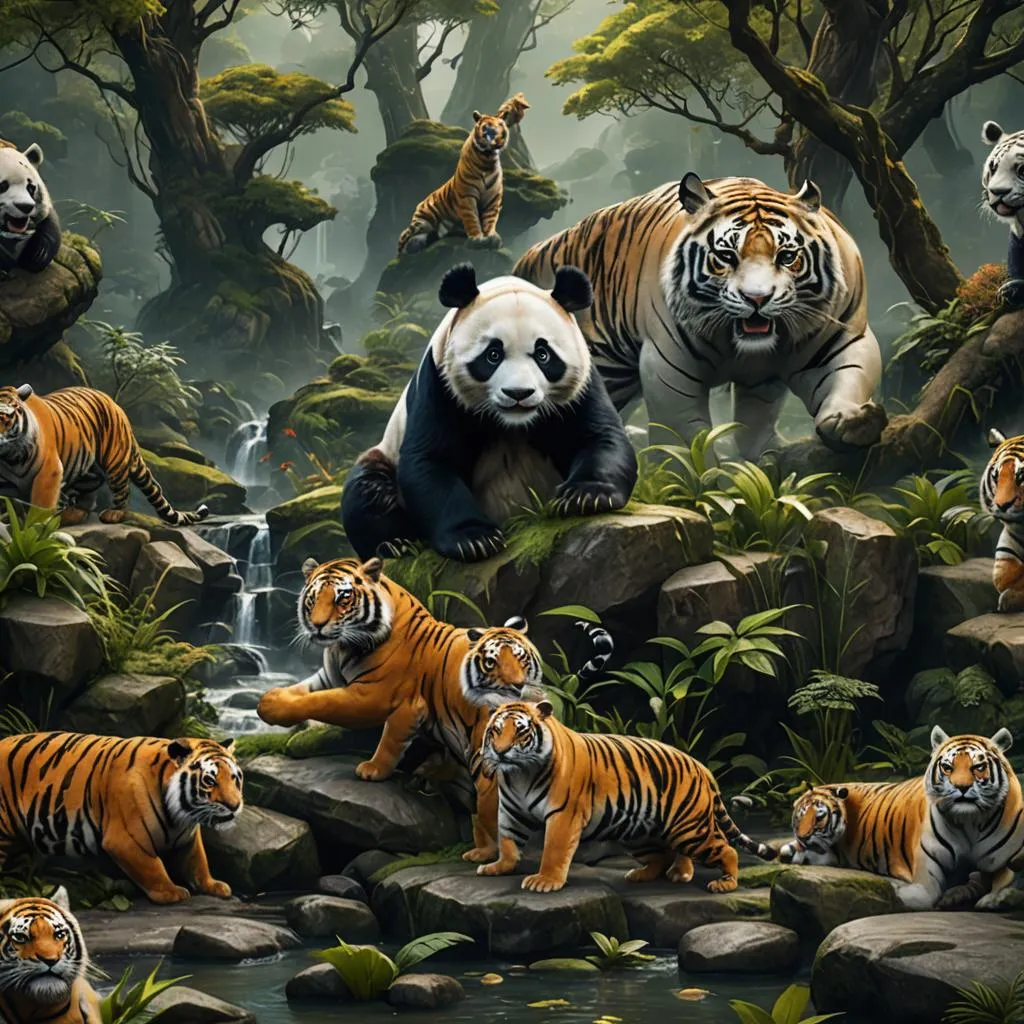

In [35]:
test_single_image(path)

In [31]:
# Compute precision, recall, F1 score
precision = metrics.precision_score(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1), average='weighted')
recall = metrics.recall_score(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1), average='weighted')
f1_score = metrics.f1_score(np.argmax(test_labels, axis=1), np.argmax(
    preds, axis=1), average='weighted')

# Compute confusion matrix
conf_matrix = metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))

# Calculate FAR and FRR
far = np.sum(conf_matrix.sum(axis=0) - np.diag(conf_matrix)) / \
    np.sum(conf_matrix.sum(axis=1))
frr = np.sum(conf_matrix.sum(axis=1) - np.diag(conf_matrix)) / \
    np.sum(conf_matrix.sum(axis=1))

# Print out the results
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))
print("False Acceptance Rate (FAR): {:.2f}".format(far))
print("False Rejection Rate (FRR): {:.2f}".format(frr))

# Calculate mAP
average_precision = metrics.average_precision_score(
    test_labels, preds, average=None)
mAP = np.mean(average_precision)
print("Mean Average Precision (mAP): {:.2f}".format(mAP))

Accuracy: 92.07%
Precision: 0.93
Recall: 0.92
F1 Score: 0.92
False Acceptance Rate (FAR): 0.08
False Rejection Rate (FRR): 0.08
Mean Average Precision (mAP): 0.88
